In [2]:
# only use one GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import setpath
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
from prepare.eegdataset import GeneralEEGImageDataset,BaseEEGImageDataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [3]:
# 画序列,# x: [batch size, 717], y: [batch size]
def draw_seq(x, y, window_size=0):
    if window_size == 0:
        # draw the mean of each image only in one plot
        fig, ax = plt.subplots(1, 1)
        # Set the figure size
        fig.set_size_inches(10, 5)
        for i in range(len(x)):
            if y is not None:
                ax.plot(x[i], label='y - '+str(y[i]))
            else:
                ax.plot(x[i], label='y')
        ax.legend()
        plt.show()
    else:
        # draw the mean of each image in a plot and the smoothed mean in another plot
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
        # Set the figure size
        fig.set_size_inches(10, 10)
        for i in range(len(x)):
            smoothed_mean = moving_average(x[i], window_size)
            if y is not None:
                ax1.plot(x[i], label='y - '+str(y[i]))
                ax2.plot(smoothed_mean, label='y - '+str(y[i]))
            else:
                ax1.plot(x[i], label='y')
                ax2.plot(smoothed_mean, label='y')
        ax1.legend()
        ax2.legend()
        plt.show()
    

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

def moving_average_images(img_seq_list, window_size=20):
    if window_size < 1 or not isinstance(window_size, int):
        raise ValueError("Window size should be a positive integer.")
    
    if len(img_seq_list) < window_size:
        raise ValueError("Window size should be smaller or equal to the number of images in the sequence.")

    averaged_images = []
    for i in range(len(img_seq_list) - window_size + 1):
        window_images = img_seq_list[i:i + window_size]
        averaged_image = np.mean(window_images, axis=0)
        averaged_images.append(averaged_image)
    
    return np.array(averaged_images)



def draw_image_means(img_seq_list,y=None, target='raw', cutpoints=None, window_size=0):
    if window_size == 0:
        # draw the mean of each image only in one plot
        fig, ax = plt.subplots(1, 1)
        # Set the figure size
        fig.set_size_inches(10, 5)
        for i in range(len(img_seq_list)):
            mean = np.mean(img_seq_list[i], axis=(1, 2))
            if y is not None:
                ax.plot(mean, label=target +' - '+str(y[i]))
            else:
                ax.plot(mean, label=target)
        if cutpoints is not None:
            for cutpoint in cutpoints:
                ax.axvline(x=cutpoint, color='r', linestyle='--')
        ax.legend()
        plt.show()
    else:
        # draw the mean of each image in a plot and the smoothed mean in another plot
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
        # Set the figure size
        fig.set_size_inches(10, 10)
        for i in range(len(img_seq_list)):
            mean = np.mean(img_seq_list[i], axis=(1, 2))
            smoothed_mean = moving_average(mean, window_size)
            if y is not None:
                ax1.plot(mean, label=target +' - '+str(y[i]))
                ax2.plot(smoothed_mean, label=target +' - '+str(y[i]))
            else:
                ax1.plot(mean, label=target)
                ax2.plot(smoothed_mean, label=target)
        if cutpoints is not None:
            for cutpoint in cutpoints:
                ax1.axvline(x=cutpoint, color='r', linestyle='--')
                ax2.axvline(x=cutpoint, color='r', linestyle='--')
        ax1.legend()
        ax2.legend()
        plt.show()

def draw(images, window_size=100, y=None):
    # window_size = img_length//10
    # print('image shape:', images.shape)
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

    for i in range(len(images)):
        mean = np.mean(images[i], axis=(1, 2))
        smoothed_mean = moving_average(mean, window_size)
        if y is not None:
            label = str(y[i])
            ax1.plot(mean, label='raw - '+label)
            ax2.plot(smoothed_mean, label='smooth - '+label)
        else:
            ax1.plot(mean, label='raw')
            ax2.plot(smoothed_mean, label='smooth')
    ax1.legend()
    ax2.legend()
    plt.show()

def divide_segments(x, grid_size):
    delta_x = np.sum(np.abs(np.diff(x, axis=0)), axis=(1, 2))
    sorted_diff = sorted(enumerate(delta_x), key=lambda x: x[1], reverse=True)
    sorted_indexes = [i for i, diff in sorted_diff][:grid_size*grid_size-1]
    sorted_indexes.sort()
    return sorted_indexes


def divide_simple_segments(x, grid_size):
    interval = len(x) / (grid_size * grid_size)
    indices = np.arange(0, len(x), interval)[1:]
    return indices.astype(int)


# 每个样本是一个图像序列，返回的是图像序列的均值序列
class TestDataset_A(BaseEEGImageDataset):

    def __getitem__(self, idx):
        filepath = self.filepaths[idx]

        with open(filepath, 'rb') as f:
            x = pickle.load(f)  # [t, w, h]
            x = x[:, 2:-2, 2:-2]  # [t, w, h]
            # 均值序列
            # x = np.mean(x, axis=(1, 2))  # [t]
            # std 序列
            x = np.std(x, axis=(1, 2))  # [t]
            x = torch.tensor(x, dtype=torch.float32)

            y = int(pickle.load(f))
            assert 0 <= y <= 39
            y = torch.tensor(y, dtype=torch.long)
        
        return x, y

In [4]:
data_path = '/data0/tianjunchao/dataset/CVPR2021-02785/data/img_pkl/32x32'
dataset = TestDataset_A(path=data_path)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=4)

In [5]:
# each class store 10 samples
class_dict = {i:[] for i in range(40)}

for i, (x,y) in enumerate(dataloader):
    x = x.numpy()
    y = y.numpy()
    
    # draw_seq(x, y)
    print(('--'*20))
    
    # save the data
    for j in range(len(x)):
        class_dict[y[j]].append(x[j])
    
    if i == 10:
        break
    


----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------


[ 6 10 12 38  5 11 23  1 13 20]
(45, 717)


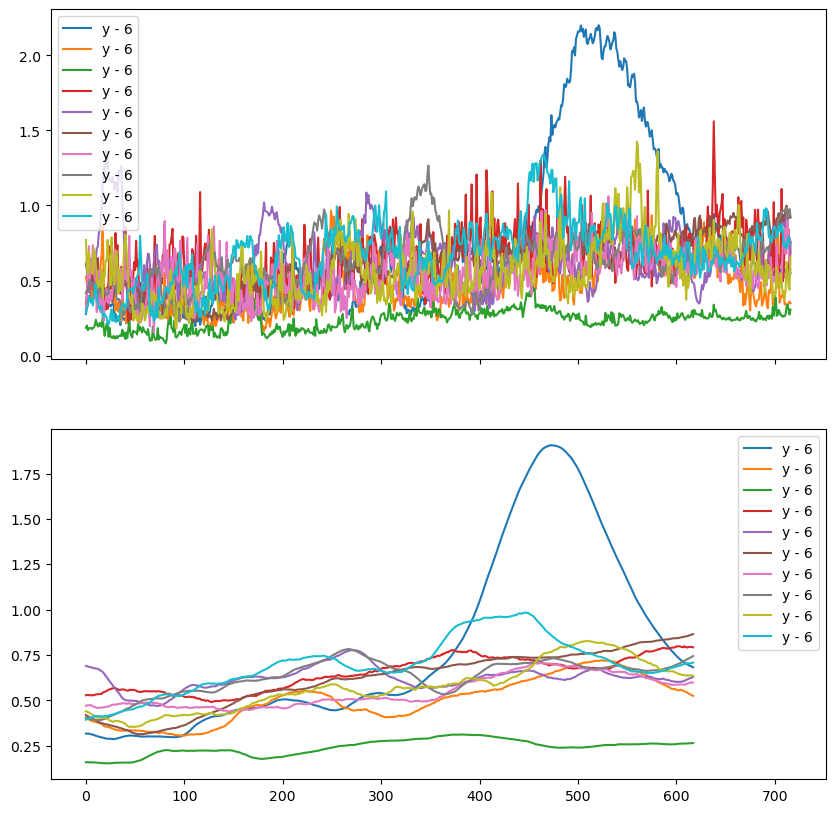

(30, 717)


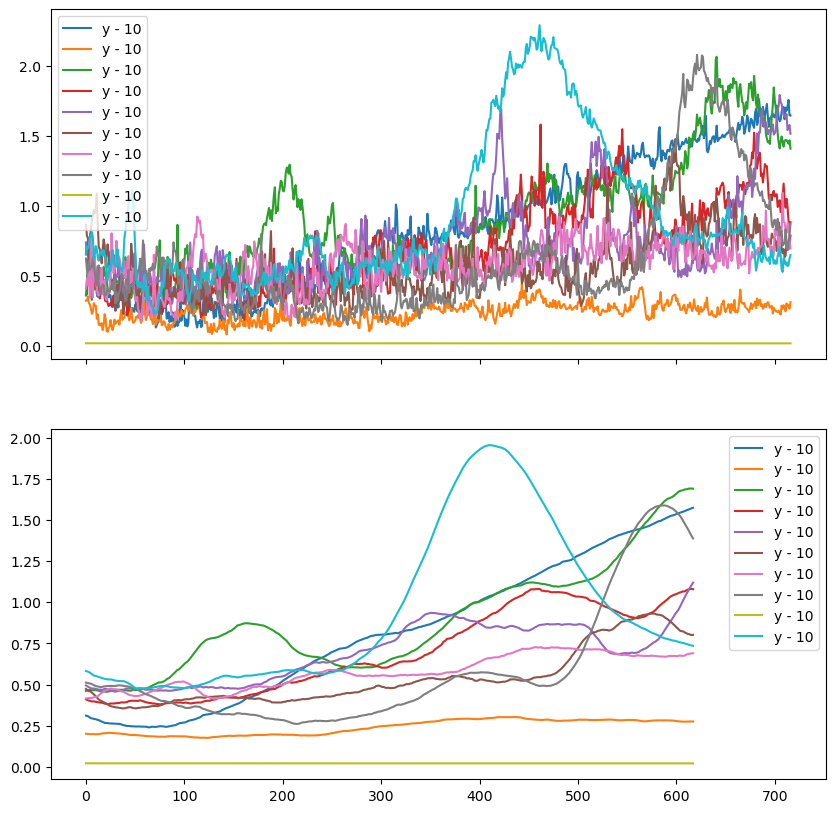

(34, 717)


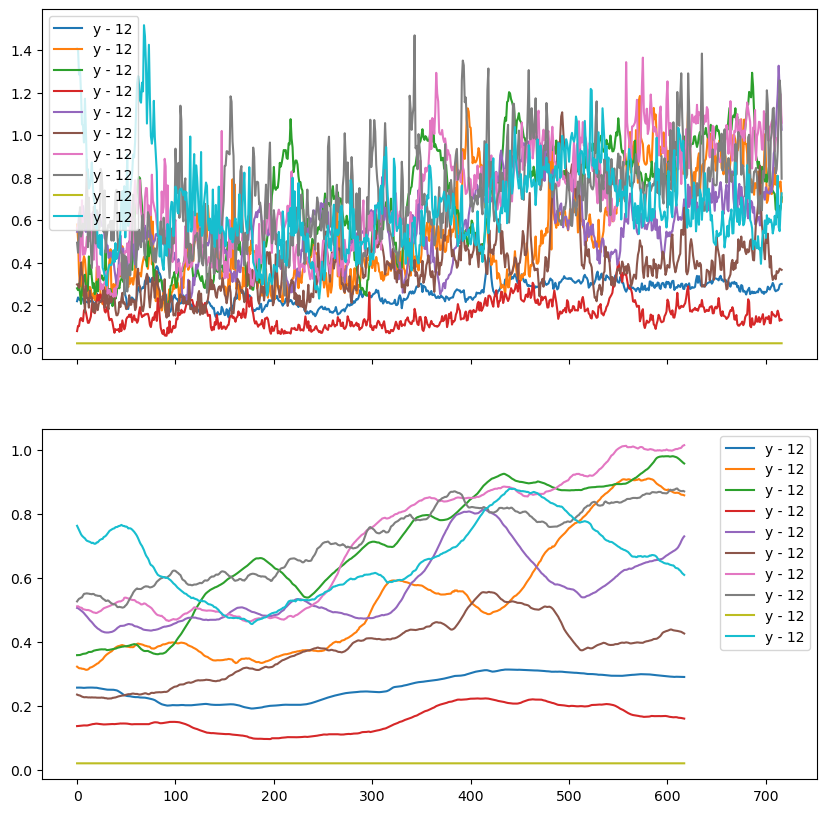

(40, 717)


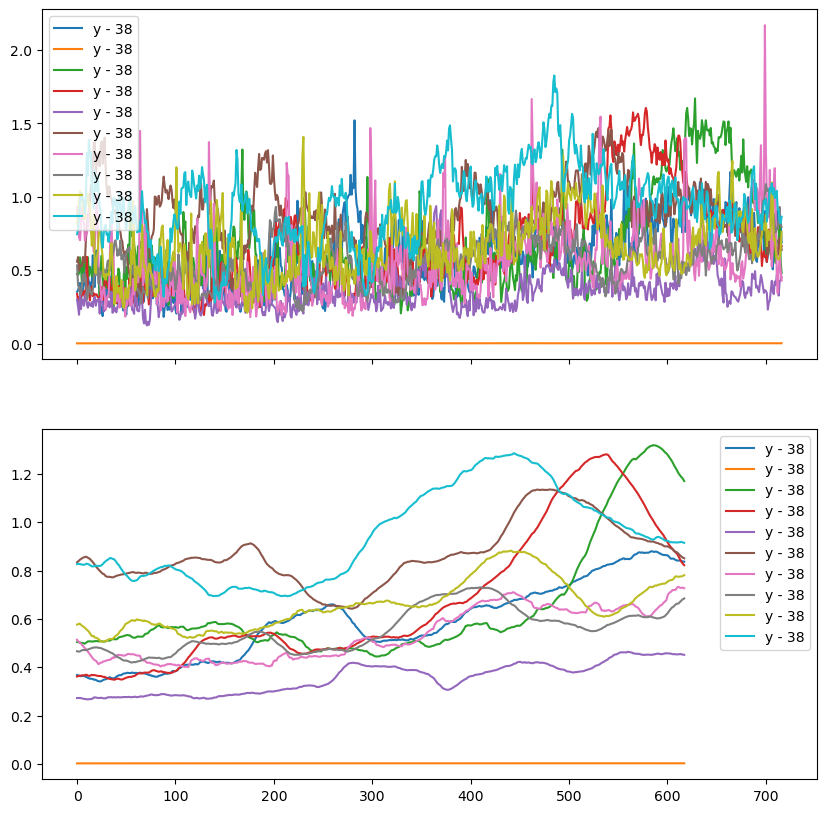

(39, 717)


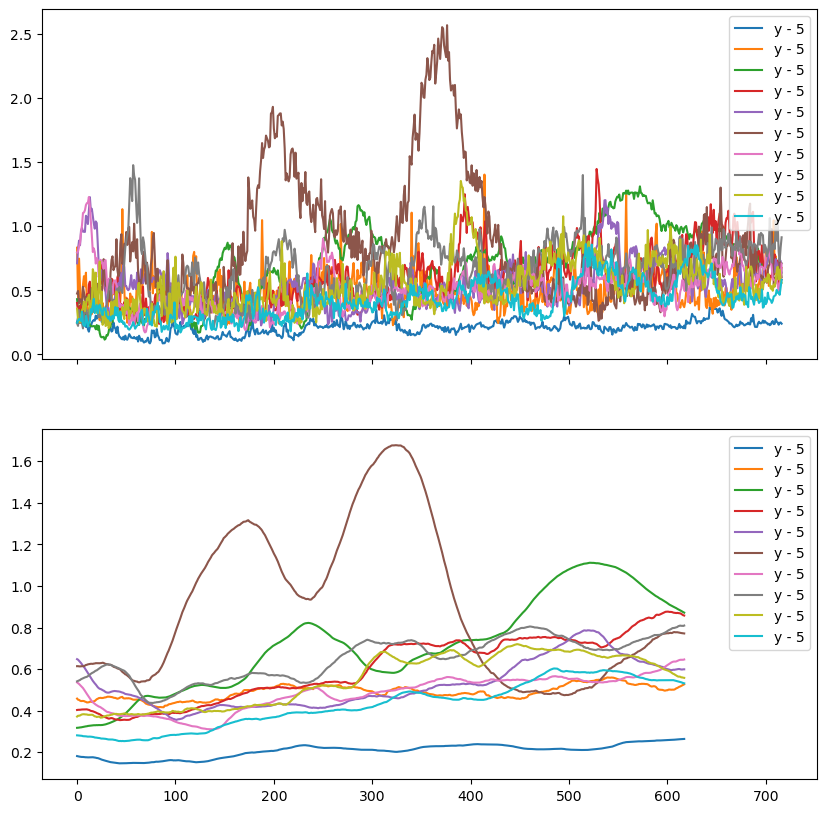

(30, 717)


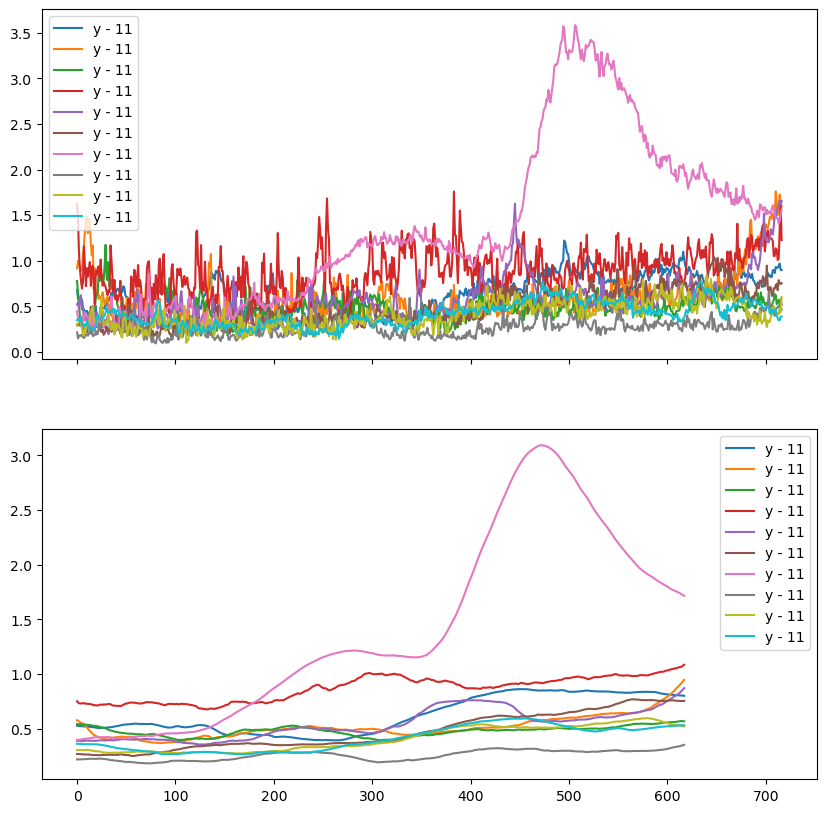

(39, 717)


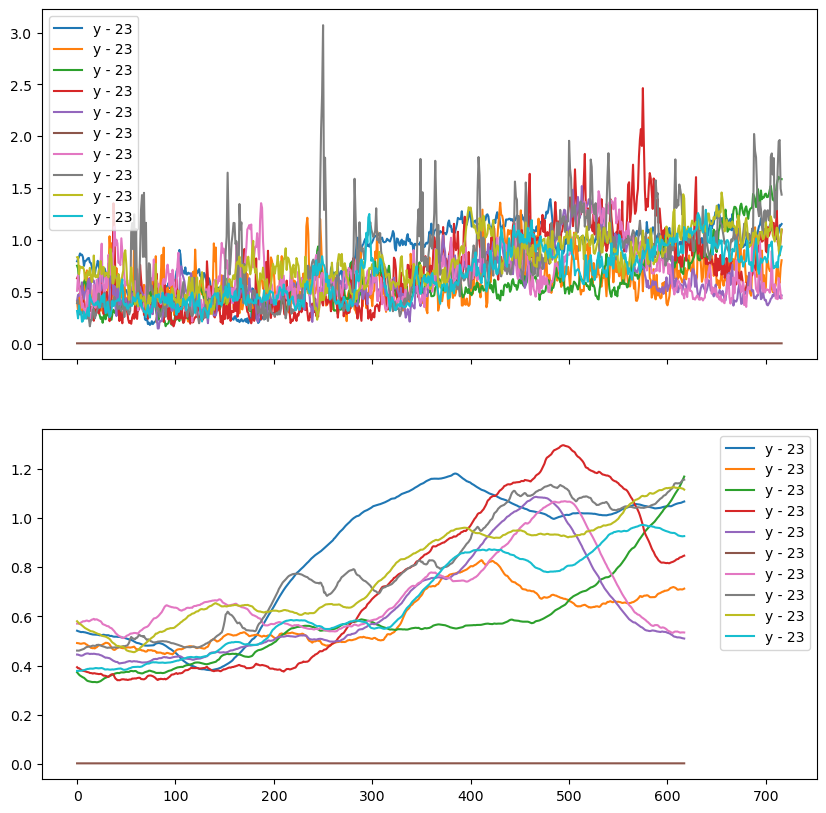

(40, 717)


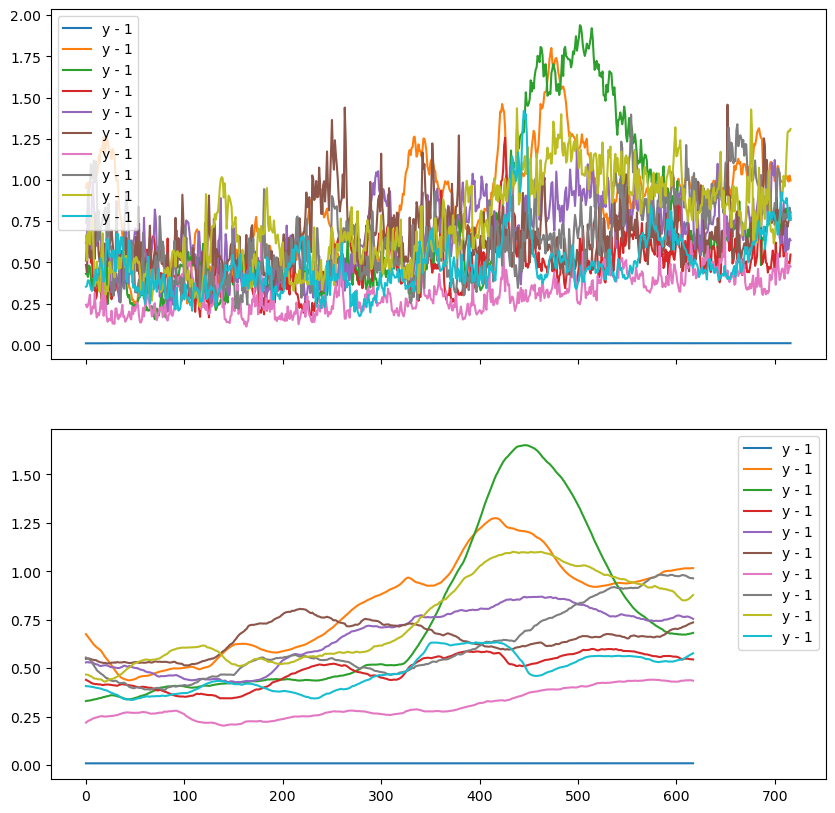

(32, 717)


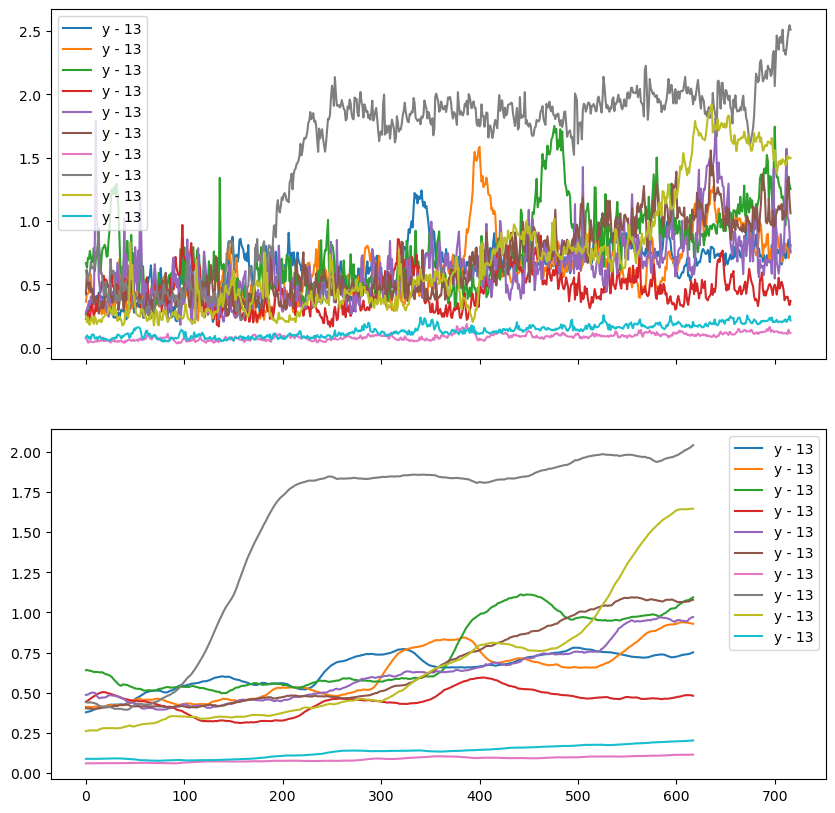

(29, 717)


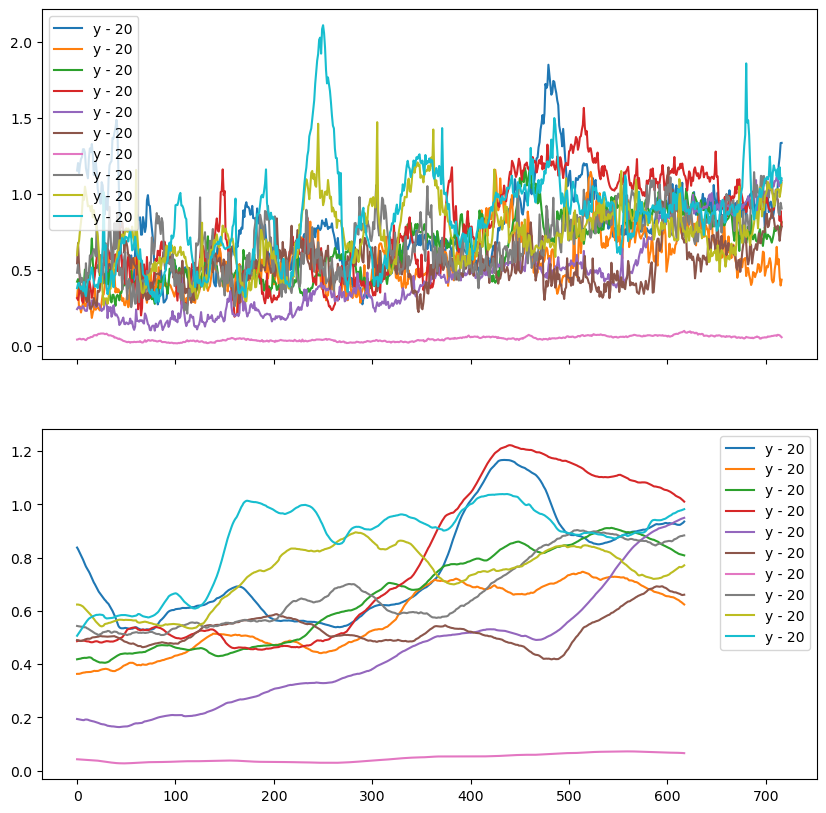

In [6]:
# randomly select 10 classes from 40 classes
random_classes = np.random.choice(40, 10, replace=False)
print(random_classes)

# draw the mean of each class
image_num = 10
for i in random_classes:
    class_dict[i] = np.array(class_dict[i])
    print(class_dict[i].shape)
    draw_seq(class_dict[i][:image_num], [i]*image_num,window_size=100)


In [7]:
class_dict[i][:5]

array([[1.153132  , 1.2026507 , 1.1364714 , ..., 1.2417232 , 1.3343906 ,
        1.335202  ],
       [0.31962803, 0.39161026, 0.24808276, ..., 0.4542219 , 0.39724666,
        0.43559062],
       [0.42261916, 0.43946588, 0.39760202, ..., 0.76358956, 0.78678364,
        0.81329656],
       [0.31382656, 0.3019728 , 0.34233233, ..., 0.8224771 , 0.8879575 ,
        0.78693914],
       [0.24201743, 0.2527622 , 0.2584899 , ..., 1.0507556 , 1.0824107 ,
        1.0865347 ]], dtype=float32)